In [1]:
# coding: utf-8

import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.spatial
import functools
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon

import unittest
T=unittest.TestCase()

#"状況,利用定員（２・３号）"は本園に合算されているので使わない
k1 = ["状況,合計", "１号,認可定員(全体)", "２号３号,利用定員（2・3号）"]
k2 = ["状況,申込児童数 %s歳児" % "０１２３４５"[i] for i in range(6)]
k3 = ["%d歳" % i for i in range(6)]
k4 = ["状況,入所の可能性 %s歳児" % i for i in "０１２３４５"]

# 補足情報を除去する
def drop_notes(c):
    if c is not None and len(c):
        m = re.match(r'^(\d+)\s*[（\()]内地域枠\d+[）\)]$', c)
        if m:
            return int(m.group(1))
        elif c[-1] in "*＊":
            return int(c[:-1])
        else:
            return int(c)
    return None

# 神戸市の人口データを読み込む。
ages = ["%d歳" % i for i in range(100)]+["100歳以上"]
def load_zensi(fname):
    e = pd.ExcelFile(fname)
    opts = dict(skiprows=1, converters={"区コード":str, "町コード":str})
    dfs = [e.parse(s, **opts).iloc[1:,:] for s in e.sheet_names if s != "神戸市"]
    return pd.DataFrame(pd.concat(dfs, ignore_index=True))

# e-Stat の区域データを読み込む。
us = [gpd.read_file(f) for f in glob.glob("../data/estat/h22ka281*.shp")]
pib_ = gpd.GeoDataFrame(pd.concat(us, ignore_index=True), crs=us[0].crs)
pib = pib_[(pib_["MOJI"]!="水面") & (pib_["MOJI"].isnull()==False)] # 海上を取り除く

be = [("minx",min), ("miny",min), ("maxx",max), ("maxy",max)]
pib_ext = [Point([be[j][1](pib.bounds[be[j][0]]) for j in i]) for i in ((0,1),(2,1),(2,3),(0,3))]

# ボロノイ図関連のルーチン
def voronoi(aib):
    # Add extra points to create closed Polygon for all facilities
    ext = []
    for pt in pib_ext:
        dist = aib.distance(pt)
        n = aib[dist==min(dist)].geometry.iloc[0]
        ext.append(Point(pt.x*2 - n.x, pt.y*2 - n.y))

    aib_ext = gpd.GeoDataFrame([dict(geometry=p, dummy=1) for p in ext])
    g = gpd.GeoDataFrame(pd.concat([aib, aib_ext], ignore_index=True))
    v = scipy.spatial.Voronoi([p.coords[0] for i,p in g.geometry.iteritems()])
    return v

def voronoi2region(aib, v, **kwargs):
    vp = [dict(geometry=Polygon([v.vertices[vt] for vt in v.regions[r]]),
            aib=aib.index[i], **kwargs)
        for i,r in enumerate(v.point_region) if -1 not in v.regions[r]]
    assert len(vp) == aib.shape[0]
    return vp

proc_data = []

def proc(shinseido, zensi, target_age):
    fib_ = gpd.read_file(shinseido)
    # そのまま集計すると、分園の数だけ二重に集計してしまう
    fib = fib_[fib_["状況,参照"]!="本園"]
    # fib のセルのいくつかは数値に補足情報が付いているので、除去する
    fib_ = fib[k1+k2].applymap(drop_notes)
    fib = fib.assign(**{k:fib_[k] for k in k1+k2})
    
    # 同一住所に複数の施設が存在したりするので、まず位置情報だけで分割できるようにする。
    coords_fib = [r.coords[0] for _,r in fib.geometry.iteritems()]
    coords = []
    for c in coords_fib:
        if c not in coords:
            coords.append(c)

    aib = gpd.GeoDataFrame([{"geometry":Point(x,y)} for x,y in coords], crs="+init=epsg:4326")
    fib_aib = pd.Series([coords.index(c) for c in coords_fib], index=fib.index, name="aib")

    zib_ = load_zensi(zensi)
    # 直接 KEYCODE1 が引けるなら、それを採用
    zib = zib_.assign(KEYCODE1=lambda df:df["町コード"][df["町コード"].isin(set(pib["KEYCODE1"]))])
    # 引けなければ、緯度経度から解決を試みる
    qname = zib_.apply(lambda r:"神戸市 %s %s" % (r["区・支所"].replace("支所",""), r["町名"]), axis=1)
    try:
        cache = pd.read_json(open("../cache/kobe.json", encoding="UTF-8")).T
    except:
        cache = pd.DataFrame([], columns=["lat", "lng"])

    qn = pd.DataFrame(qname, columns=["qname"])
    qa = qn[zib["町コード"].isin(set(pib["KEYCODE1"]))==False].join(cache, on="qname", how="inner")
    pt = gpd.GeoDataFrame(qa.apply(lambda r:Point(r["lng"], r["lat"]), axis=1), columns=["geometry"], crs="+init=epsg:4326")
    pt_mv = gpd.tools.sjoin(pt, pib.to_crs("+init=epsg:4326"), op="within")
    zib.loc[pt_mv.index, "KEYCODE1"] = pt_mv["KEYCODE1"]

    # pib に人口を割り当てる
    pib_pop = pib.join(
        zib.groupby("KEYCODE1").sum()[k3],
        on="KEYCODE1"
    ).join(
        pd.concat([pib["KEYCODE1"], pib.geometry.area], axis=1).groupby("KEYCODE1").sum().rename(columns={0:"area_sum"}),
        on="KEYCODE1"
    )
    for k in k3:
        pib_pop = pib_pop.assign(**{k:lambda d:d[k] * pib_pop.geometry.area / pib_pop["area_sum"]})

    for k in k3:
        T.assertAlmostEqual( pib_pop.sum()[k], zib.sum()[k] )

    # pib で平滑化をする
    cpib_ = gpd.GeoDataFrame(pd.concat([pib["geometry"],
        pd.Series(pib.index, index=pib.index, name="pib")], axis=1)).assign(one=1)
    cpib = gpd.tools.sjoin(cpib_, cpib_, op="intersects")

    pib_pop2_ = cpib.join(
        cpib.groupby("pib_left").sum()["one_left"].rename("counts"),
        on="pib_left"
    ).join(
        pib_pop[k3],
        on="pib_left"
    )
    for k in k3:
        pib_pop2_[k] = pib_pop2_[k] / pib_pop2_["counts"]
    pib_pop2 = pib_pop2_.groupby("pib_right").sum()

    # 合計値の検算
    for k in k3:
        T.assertAlmostEqual( pib_pop2.sum()[k], zib.sum()[k] )

    zib_age = ["%d歳" % i for i in range(6)][target_age]
    fib_age = ["状況,申込児童数 %s歳児" % s for s in "０１２３４５"][target_age]
    
    fibi = (fib[fib_age].isnull()==False)
    fib2 = fib[fibi]

    # CRS は面積の計算できる座標系に揃える。
    aib2 = aib.to_crs(pib.crs).loc[set(fib_aib[fibi])]
    v = voronoi(aib2)
    r2 = gpd.GeoDataFrame(voronoi2region(aib2, v), crs=pib.crs)
    aib2_neigh = pd.DataFrame(np.r_[
        v.ridge_points,
        v.ridge_points.dot(np.array([[0,1],[1,0]])),
        np.array([[i, i] for i in range(len(aib2.index))])
    ], columns=["L","R"]).applymap(
        lambda x:aib2.index[x] if x<len(aib2.index) else None
    ).dropna()

    pib_ = gpd.GeoDataFrame(pd.concat([pib,
        pd.Series(pib.index, index=pib.index, name="pib")], axis=1))
    ta = gpd.overlay(pib_, r2, how="union") # この計算は重い！

    tv = ta[ta["pib"].isnull()==False]
    tv.crs = pib.crs

    tv_pop = tv.join(
        pd.concat([(tv.geometry.area).rename("pib_area"), tv], axis=1).groupby("pib").sum()["pib_area"],
        on="pib"
    ).join(
        pib_pop2[zib_age],
        on="pib"
    ).assign(
        tv_pop = lambda df:df[zib_age] * df.geometry.area / df["pib_area"]
    )
    aib_pop = tv_pop.groupby("aib").sum()["tv_pop"].rename("aib_pop")
    
    # aib を平滑化
    aib_neigh_pop_sum = aib2_neigh.join(
        aib2_neigh.join(aib_pop, on="L").groupby("R").sum()["aib_pop"].rename("wide_sum"),
        on="L"
    ).join(
        aib_pop,
        on="R"
    )
    aib_wait = pd.merge(aib_neigh_pop_sum, pd.concat([fib2, fib_aib[fibi]], axis=1), left_on="L", right_on="aib").assign(
        aib_wait=lambda df:df[fib_age] * df["aib_pop"] / df["wide_sum"]
    ).groupby("R").sum()["aib_wait"]
    
    pti_g_ = [functools.reduce(lambda x,y:x.union(y), tv[tv["aib"]==pti].geometry) for pti in aib2.index]
    pti_g = pd.Series(pti_g_, index=aib2.index, name="geometry")
    
    return gpd.GeoDataFrame(
        pd.concat([pti_g, (aib_wait/aib_pop).rename("rate")], axis=1),
        crs=pib.crs)

titles = ["2016-%02d" % (i+5) for i in range(6)]
fns = (
    ("../data/hkwi/shinseido-2016-05.json","../data/kobe/zensi2805.xls"),
    ("../data/hkwi/shinseido-2016-06.json","../data/kobe/zensi2805.xls"),
    ("../data/hkwi/shinseido-2016-07.json","../data/kobe/zensi2806.xls"),
    ("../data/hkwi/shinseido-2016-08.json","../data/kobe/zensi2807.xls"),
    ("../data/hkwi/shinseido-2016-09.json","../data/kobe/zensi2808.xls"),
)

In [2]:
%matplotlib nbagg
import matplotlib.animation

<IPython.core.display.Javascript object>


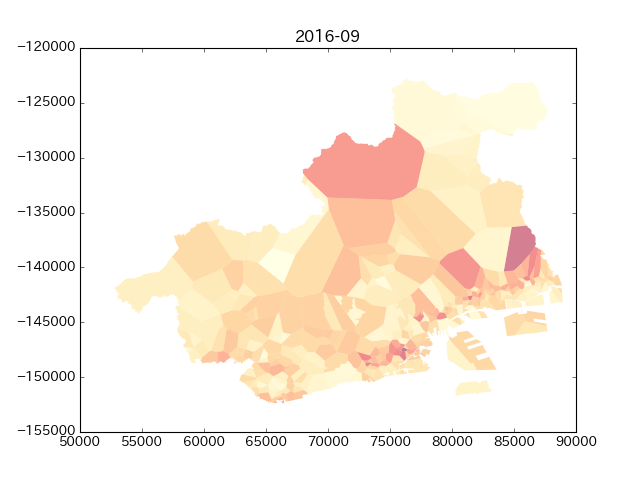

<IPython.core.display.Javascript object>


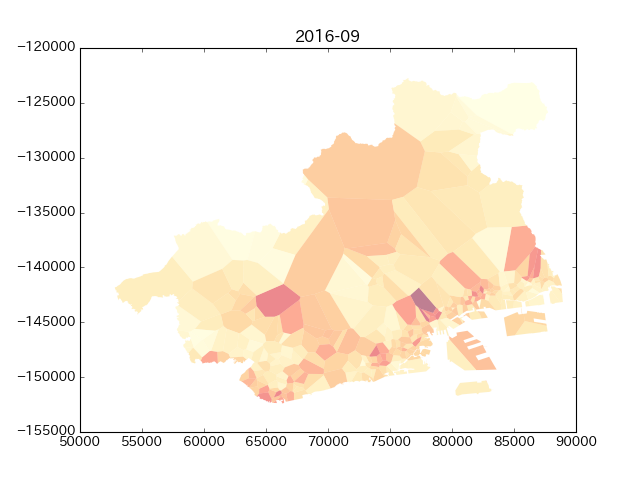

<IPython.core.display.Javascript object>


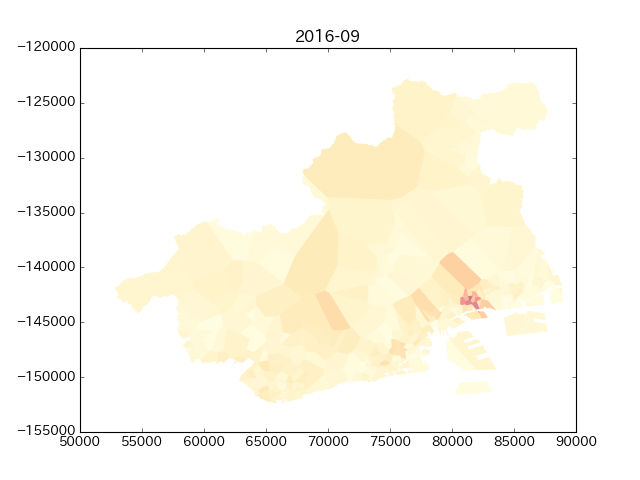

<IPython.core.display.Javascript object>


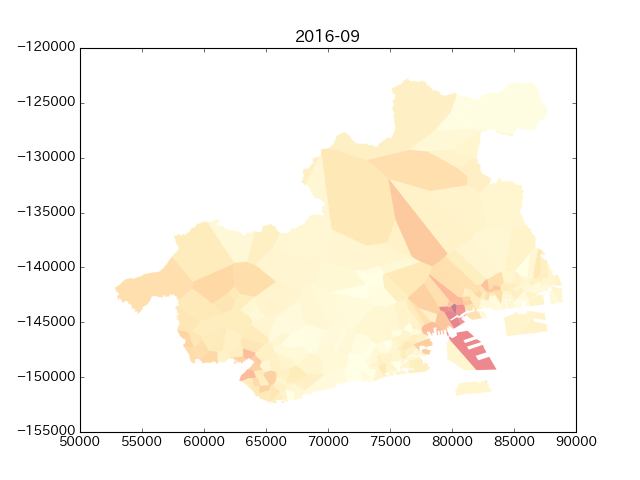

<IPython.core.display.Javascript object>


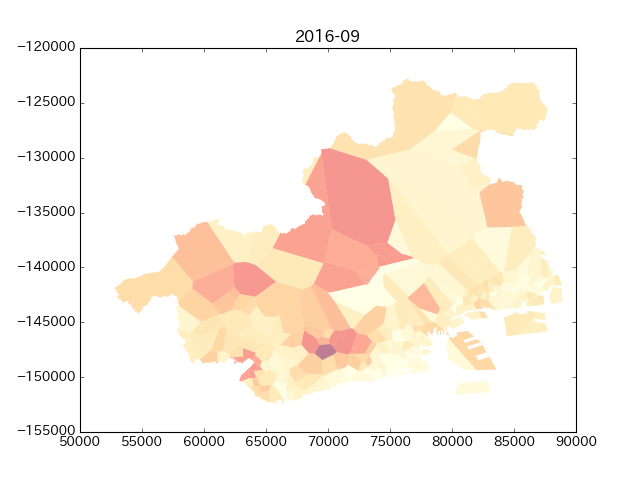

<IPython.core.display.Javascript object>


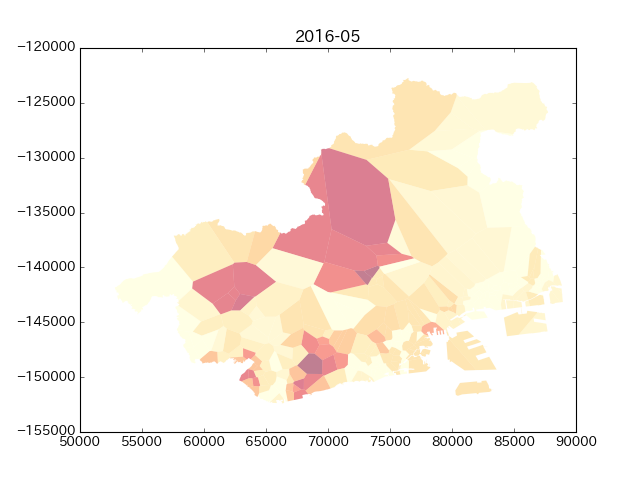

In [3]:
Writer = matplotlib.animation.writers["ffmpeg"]

for age in range(6):
    capture = {}
    for t,fn in enumerate(fns):
        shinseido_name,zensi_name = fn
        capture[(age, t)] = proc(shinseido_name, zensi_name, age)
    
    fig, ax = plt.subplots()

    def update(t):
        ax.cla()
        ax.title.set_text(titles[t])
        g = capture[(age, t)]
        g.plot(column="rate", cmap="YlOrRd", linewidth=0, ax=ax)

    ani = matplotlib.animation.FuncAnimation(fig, update, frames=range(len(fns)), interval=1000, repeat_delay=1000)
    ani.save("../docs/data/2016-10-07-age%d.mp4" % age,
        writer=Writer(fps=2, codec="libx264", bitrate=1800,
        extra_args=["-profile:v", "baseline", "-pix_fmt","yuv420p"]))